#### 1. **Introduction to Real-Time Monitoring and Drift Detection**

This tutorial demonstrates how to use the `ModelRunnerStep` within a serving graph to enable real-time monitoring and drift detection with MLRun. This process involves creating a custom model serving function that is integrated with a monitoring service.

In [1]:

from mlrun import get_or_create_project

image = "mlrun/mlrun"
project_name = "monitored-model-runner"
project = get_or_create_project(project_name, context="./",user_project=True)

> 2025-10-20 10:22:01,586 [info] Project loaded successfully: {"project_name":"monitored-model-runner-shapira"}


#### 3. Logging Your Model

The model artifact is essential for integrating your trained model into the `mlrun.serving.Model` class. This step logs your model so it can be accessed and used by the serving function later in the pipeline.

In [3]:
import pandas as pd
from sklearn.svm import SVC
import pickle
from sklearn.datasets import load_iris
from mlrun.features import Feature

iris = load_iris()
clf = SVC()
clf.fit(iris.data, iris.target)
with open("RandomForestClassifier.pkl", "wb") as fh:
    pickle.dump(clf, fh)
iris_data = iris["data"].tolist()

iris = load_iris()
train_set = pd.DataFrame(
    iris["data"],
    columns=["sepal_length_cm", "sepal_width_cm", "petal_length_cm", "petal_width_cm"],
)

model_name = "RandomForestClassifier"
model_artifact = project.log_model(
    model_name,
    model_file="RandomForestClassifier.pkl",
    training_set=train_set,
    framework="sklearn",
    outputs=[Feature(name="label")],
)

#### 4. Custom Model and Step Implementation

This section is where you implement your custom model code. You will define classes for your model, a model selector, and any preprocessing or enrichment steps required for your serving graph.

-   `MyModel(Model)`: This class encapsulates your machine learning model. The `load` method handles loading the model artifact, and the `predict` method defines how the model generates predictions.
-   `MyModelSelector(ModelSelector)`: This class allows the `ModelRunnerStep` to dynamically select which models to run based on the incoming event data.
-   `MyPreprocessStep(MapClass)`: This is a custom step for preprocessing the input data before it reaches the model runner.
-   `MyEnrichStep(MapClass)`: This is a custom step to enrich the output event, in this case by adding a timestamp.

In [19]:
%%writefile model_class.py
import numpy as np

from mlrun.serving.states import Model, ModelSelector
from typing import Optional
from cloudpickle import load
from storey import MapClass



class MyModel(Model):
    def __init__(self, *args, artifact_uri: str = None, raise_exception = False, **kwargs):
        super().__init__(*args, artifact_uri=artifact_uri, raise_exception=raise_exception, **kwargs)
    
    def load(self):
        """load and initialize the model and/or other elements"""
        model_file, _ = self.get_local_model_path(".pkl")
        self.model = load(open(model_file, "rb"))
    
    def predict(self, body: dict, **kwargs) -> dict:
        """Generate model predictions from sample."""
        print("sync")
        feats = np.asarray(body["inputs"]["here"])
        result: np.ndarray = self.model.predict(feats)
        return {"outputs": {"label" :result.tolist()}}

    async def predict_async(self, body: dict, **kwargs) -> dict:
        """Generate model predictions from sample."""
        print("async")
        feats = np.asarray(body["inputs"]["here"])
        result: np.ndarray = self.model.predict(feats)
        return {"outputs": {"label" :result.tolist()}}

    
class MyModelSelector(ModelSelector):
    def __init__(self, name:str):
        super().__init__()
        self.name = name
    
    """Selector allows the ModelRunnerStep to run some of models provided based on the event"""
    def select(self, event, available_models: list[Model]) -> Optional[list[str]]:
        return event.body.get("models")
    
    
class MyEnrichStep(MapClass):
    def do(self, event):
        event["timestamp"] = str(datetime.now().timestamp())
        return event


class MyPreprocessStep(MapClass):
    def do(self, event):
        inputs = event.pop("inputs")
        event["inputs"] = {"here": inputs}
        return event
        

Overwriting model_class.py


#### 5. Define your function and ModelRunnerStep

This section defines your serving function and the `ModelRunnerStep`. The `ModelRunnerStep` allows you to run multiple models in parallel, each with its own configuration, and it integrates seamlessly with the rest of your serving graph.

In [20]:
code_path = r"sync async/model_class.py"
function = project.set_function(func=code_path,image="mlrun/mlrun",kind="serving",name="serving-function")


In [21]:
from mlrun.serving.states import ModelRunnerStep
from model_class import MyModel, MyModelSelector

model_runner_step = ModelRunnerStep(
    name="my_runner", model_selector="MyModelSelector",model_selector_parameters={"name":"my-selector"})

model_runner_step.add_model(
    model_class="MyModel",
    endpoint_name="my-model",
    model_artifact=model_artifact,
    input_path="inputs.here",
    result_path="outputs",
    outputs=["label"],
    execution_mechanism="thread_pool",
)
for i in range(2):
    model_runner_step.add_model(
        model_class="MyModel",
        endpoint_name=f"my-{i}-model",
        model_artifact=model_artifact,
        input_path="inputs.here",
        result_path="outputs",
        outputs=["label"],
        execution_mechanism="thread_pool",
    )

#### 6. Build your graph and enable tracking

This section builds the serving graph by connecting the preprocessing step, the model runner step, and the enrichment step. It also enables tracking for real-time monitoring and drift detection.

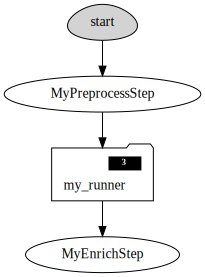

In [ ]:
graph = function.set_topology("flow",engine="async")
graph.to("MyPreprocessStep").to(model_runner_step).to("MyEnrichStep").respond()
graph.plot()

#### 7. Deploying Your Function

Running this cell will deploy your serving function to the cluster. This also deploys the real-time monitoring functions for your project, which are configured to track the serving function's performance and detect model drift.

In [23]:
function.deploy()

> 2025-10-21 10:48:26,215 [info] Starting remote function deploy
2025-10-21 10:48:27  (info) Deploying function
2025-10-21 10:48:27  (info) Building
2025-10-21 10:48:27  (info) Staging files and preparing base images
2025-10-21 10:48:27  (warn) Using user provided base image, runtime interpreter version is provided by the base image
2025-10-21 10:48:27  (info) Building processor image
2025-10-21 10:49:42  (info) Build complete
2025-10-21 10:49:50  (info) Function deploy complete
> 2025-10-21 10:49:57,844 [info] Model endpoint creation task completed with state succeeded
> 2025-10-21 10:49:57,845 [info] Successfully deployed function: {"external_invocation_urls":["monitored-model-runner-shapira-serving-function.default-tenant.app.cust-cs-il.iguazio-cd0.com/"],"internal_invocation_urls":["nuclio-monitored-model-runner-shapira-serving-function.default-tenant.svc.cluster.local:8080"]}


'http://monitored-model-runner-shapira-serving-function.default-tenant.app.cust-cs-il.iguazio-cd0.com/'

#### 8. Invoke your model

This section demonstrates how to invoke your model using the `invoke` method. It sends a request with sample data points to the deployed function, which will return predictions from the specified models.

In [9]:
from random import choice
from datetime import datetime

iris_data = iris["data"].tolist()
data_point = choice(iris_data)
response = function.invoke(
    "/",
    body={
        "models": None,
        "inputs": [data_point, data_point],
    },
)

In [30]:
response

{'my-model': {'outputs': {'label': [0, 0]}},
 'my-0-model': {'outputs': {'label': [0, 0]}},
 'my-1-model': {'outputs': {'label': [0, 0]}},
 'my-2-model': {'outputs': {'label': [0, 0]}},
 'my-3-model': {'outputs': {'label': [0, 0]}},
 'my-4-model': {'outputs': {'label': [0, 0]}},
 'my-5-model': {'outputs': {'label': [0, 0]}},
 'my-6-model': {'outputs': {'label': [0, 0]}},
 'my-7-model': {'outputs': {'label': [0, 0]}},
 'my-8-model': {'outputs': {'label': [0, 0]}},
 'my-9-model': {'outputs': {'label': [0, 0]}},
 'my-10-model': {'outputs': {'label': [0, 0]}},
 'my-11-model': {'outputs': {'label': [0, 0]}},
 'my-12-model': {'outputs': {'label': [0, 0]}},
 'my-13-model': {'outputs': {'label': [0, 0]}},
 'my-14-model': {'outputs': {'label': [0, 0]}},
 'my-15-model': {'outputs': {'label': [0, 0]}},
 'my-16-model': {'outputs': {'label': [0, 0]}},
 'my-17-model': {'outputs': {'label': [0, 0]}},
 'my-18-model': {'outputs': {'label': [0, 0]}},
 'my-19-model': {'outputs': {'label': [0, 0]}},
 'my-

In [31]:
from random import choice

iris_data = iris["data"].tolist()
data_point = choice(iris_data)
print(f"Data point:{data_point}")
response = function.invoke(
    "/", body={"models": ['my-13-model','my-16-model'], "inputs": [data_point, data_point]}
)

Data point:[4.7, 3.2, 1.6, 0.2]


In [32]:
response

{'my-13-model': {'outputs': {'label': [0, 0]}},
 'my-16-model': {'outputs': {'label': [0, 0]}},
 'timestamp': '1760627754.39966'}